In [1]:
import json
import spacy
from bs4 import BeautifulSoup
import string

# Load JSON data
with open('/Users/yimi/Downloads/output_modified.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Define custom stopwords
custom_stopwords = ["'s", "company", "``"]

# Function to process and preprocess the text
def preprocess_text(text):
    # Parse the text using spaCy
    doc = nlp(text)

    # Remove stopwords and custom stopwords, as well as punctuation
    tokens = [token.text for token in doc if not token.is_stop and token.text not in custom_stopwords and token.text not in string.punctuation]

    # Join the tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Create an empty list to store processed data
processed_data = []

# Iterate over each item in the data
for item in data:
    # Create a copy of the original item
    processed_item = item.copy()

    # Extract the "news" field from each item and remove <p> and </p> tags
    text_data = processed_item["news"]
    text_data = BeautifulSoup(text_data, "html.parser").get_text()
    text_data = text_data.replace('<p>', '').replace('</p>', '')

    # Lowercase the text
    text_data = text_data.lower()

    # Preprocess the text using spaCy, custom stopwords, and remove punctuation
    processed_text = preprocess_text(text_data)

    # Add the processed text back to the item
    processed_item["processed_news"] = processed_text

    # Append the modified item to the processed_data list
    processed_data.append(processed_item)

# Save the processed data to a new JSON file
output_file_path = '/Users/yimi/Downloads/output_processed.json'
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(processed_data, json_file, ensure_ascii=False, indent=4)

print(f"Processed data saved to: {output_file_path}")


Processed data saved to: /Users/yimi/Downloads/output_processed.json


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a list to store processed text
processed_text_list = [item["processed_news"] for item in data]

# Vectorize the processed text using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_text_list)

# Now, tfidf_matrix contains the TF-IDF representation of the processed_news field

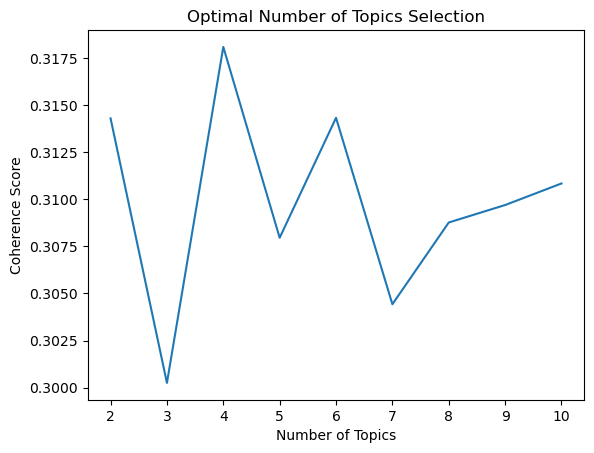

In [5]:
import json
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Create a list to store processed text
processed_text_list = [item["processed_news"].split() for item in data]

# Create a dictionary and a corpus
dictionary = Dictionary(processed_text_list)
corpus = [dictionary.doc2bow(text) for text in processed_text_list]

# Evaluate coherence for different num_topics
coherence_values = []
for num_topics in range(2, 11):  # Adjust the range as needed
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    coherence_model = CoherenceModel(model=lda_model, texts=processed_text_list, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# Plot the coherence values
import matplotlib.pyplot as plt

plt.plot(range(2, 11), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Selection")
plt.show()

In [6]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Create a list to store processed text
processed_text_list = [item["processed_news"] for item in data]

# Vectorize the processed text using CountVectorizer with stop words
vectorizer = CountVectorizer(stop_words='english') 
X = vectorizer.fit_transform(processed_text_list)

# Apply Latent Dirichlet Allocation
num_topics = 4  
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-5-1:-1]  # Display top 5 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: stevia, cell, neostem, therapy, stem
Topic #2: cancer, stock, market, million, drug
Topic #3: phase, trial, data, cancer, patients
Topic #4: week, shares, market, year, medical


In [10]:
# Create a list to store processed text
processed_text_list = [item["processed_news"] for item in data]

# Vectorize the processed text using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_text_list)

# Apply Latent Dirichlet Allocation
num_topics = 6  # You can adjust the number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-5-1:-1]  # Display top 5 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: stevia, sugar, cola, products, coca
Topic #2: stock, market, million, sales, product
Topic #3: cancer, phase, data, patients, trial
Topic #4: cancer, cells, treatment, phase, drug
Topic #5: stock, week, market, year, investors
Topic #6: cell, neostem, therapy, stem, cells


In [11]:
# Get the dominant topic for each document
doc_topics = lda.transform(X)
dominant_topics = [topic.argmax() + 1 for topic in doc_topics]  # Adding 1 to match topic indexing

# Display the top words for each topic along with the associated document
feature_names = vectorizer.get_feature_names_out()
for i, (topic_idx, topic) in enumerate(zip(dominant_topics, doc_topics)):
    top_words_idx = lda.components_[topic_idx - 1].argsort()[:-5-1:-1]  # Display top 5 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"news #{i + 1} (Topic #{topic_idx}): {', '.join(top_words)}")

news #1 (Topic #2): stock, market, million, sales, product
news #2 (Topic #2): stock, market, million, sales, product
news #3 (Topic #2): stock, market, million, sales, product
news #4 (Topic #2): stock, market, million, sales, product
news #5 (Topic #2): stock, market, million, sales, product
news #6 (Topic #2): stock, market, million, sales, product
news #7 (Topic #4): cancer, cells, treatment, phase, drug
news #8 (Topic #5): stock, week, market, year, investors
news #9 (Topic #3): cancer, phase, data, patients, trial
news #10 (Topic #4): cancer, cells, treatment, phase, drug
news #11 (Topic #4): cancer, cells, treatment, phase, drug
news #12 (Topic #2): stock, market, million, sales, product
news #13 (Topic #5): stock, week, market, year, investors
news #14 (Topic #4): cancer, cells, treatment, phase, drug
news #15 (Topic #4): cancer, cells, treatment, phase, drug
news #16 (Topic #5): stock, week, market, year, investors
news #17 (Topic #5): stock, week, market, year, investors
news

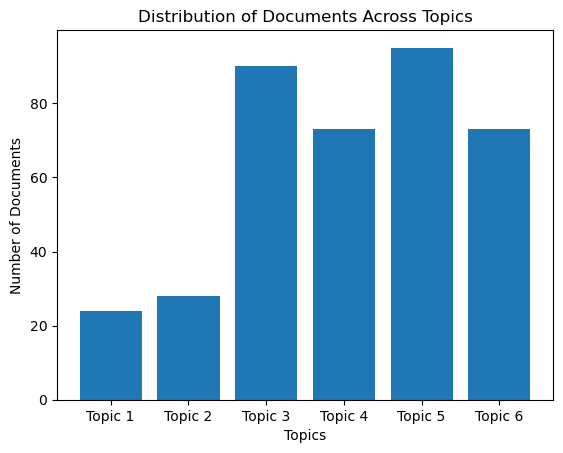

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Get the dominant topic for each document
doc_topics = lda.transform(X)
dominant_topics = [topic.argmax() + 1 for topic in doc_topics]  # Adding 1 to match topic indexing

# Count the number of documents per topic
topic_counts = np.bincount(dominant_topics)[1:]

# Create a bar plot
plt.bar(range(1, num_topics + 1), topic_counts, tick_label=[f'Topic {i}' for i in range(1, num_topics + 1)])
plt.xlabel('Topics')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Topics')
plt.show()

In [13]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [8]:
import json
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim

# Read data from the JSON file
with open('/Users/yimi/Downloads/output_processed.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)
    
# Create a list to store processed text
processed_text_list = [item["processed_news"] for item in data]

# Create a dictionary and corpus
dictionary = corpora.Dictionary([processed_text.split() for processed_text in processed_text_list])
corpus = [dictionary.doc2bow(processed_text.split()) for processed_text in processed_text_list]

# Apply Latent Dirichlet Allocation
num_topics = 6 
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

# Visualize the topics without parallel processing
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008212 -0.003623       1        1  19.542406
0     -0.006816 -0.003836       2        1  17.798551
4     -0.002227  0.005715       3        1  17.601039
1      0.003017  0.003120       4        1  16.216455
5     -0.000368  0.003046       5        1  15.847590
3     -0.001818 -0.004421       6        1  12.993959, topic_info=           Term         Freq        Total Category  logprob  loglift
354       stock  2084.000000  2084.000000  Default  30.0000  30.0000
1024     cancer  2624.000000  2624.000000  Default  29.0000  29.0000
88         data  1719.000000  1719.000000  Default  28.0000  28.0000
7251    neostem   862.000000   862.000000  Default  27.0000  27.0000
267       phase  2032.000000  2032.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
88         data   176.902877  1719.803678   Topic6  -5.5368  -0.2337
283   potential   159.799541  1478.922358   Topic6  -5.6385  -0.1845
717     million   182.535843  2012.227307   Topic6  -5.5054  -0.3594
501       sales   122.741538  1016.643496   Topic6  -5.9023  -0.0735
201        long   109.345942   781.469482   Topic6  -6.0179   0.0740

[554 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5292      1  0.180437       +1
5292      2  0.090219       +1
5292      3  0.180437       +1
5292      4  0.090219       +1
5292      5  0.270656       +1
...     ...       ...      ...
403       2  0.336646  zertane
403       3  0.149621  zertane
403       4  0.074810  zertane
403       5  0.149621  zertane
403       6  0.187026  zertane

[1679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 6, 4])

In [46]:
import json
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim

# Read data from the JSON file
with open('/Users/yimi/Downloads/output_processed.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)
    
# Create a list to store processed text
processed_text_list = [item["processed_news"] for item in data]

# Create a dictionary and corpus
dictionary = corpora.Dictionary([processed_text.split() for processed_text in processed_text_list])
corpus = [dictionary.doc2bow(processed_text.split()) for processed_text in processed_text_list]

# Apply Latent Dirichlet Allocation
num_topics = 4 
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

# Visualize the topics without parallel processing
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.002704  0.005647       1        1  29.916922
0     -0.006807 -0.000238       2        1  26.242444
2      0.006298 -0.003386       3        1  25.593828
3     -0.002194 -0.002023       4        1  18.246806, topic_info=         Term         Freq        Total Category  logprob  loglift
1024   cancer  2592.000000  2592.000000  Default  30.0000  30.0000
354     stock  2108.000000  2108.000000  Default  29.0000  29.0000
7251  neostem   840.000000   840.000000  Default  28.0000  28.0000
382     trial  1586.000000  1586.000000  Default  27.0000  27.0000
2986   neuvax   512.000000   512.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
3        2012   162.373406   851.567529   Topic4  -5.9620   0.0440
382     trial   236.043217  1586.788326   Topic4  -5.5879  -0.2043
295   product   186.204327  1088.024759   Topic4  -5.8250  -0.0641
717   million   249.722127  2045.349771   Topic4  -5.5315  -0.4018
501     sales   172.038837  1022.564585   Topic4  -5.9042  -0.0812

[385 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1542       1  0.379747        1
1542       2  0.215459        1
1542       3  0.242392        1
1542       4  0.164288        1
2026       1  0.438876      100
...      ...       ...      ...
19322      4  0.269349      zap
403        1  0.152511  zertane
403        2  0.457533  zertane
403        3  0.152511  zertane
403        4  0.266894  zertane

[992 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

In [ ]:
pip install empath

In [17]:
import json
from empath import Empath

# Initialize the Empath lexicon
lexicon = Empath()

# Read data from the JSON file
with open('/Users/yimi/Downloads/output_modified.json', 'r', encoding='utf-8') as json_file:
    news_articles = json.load(json_file)

# Perform empath analysis on each article and store the results in a list
results = []

for article in news_articles:
    article_text = article["processed_news"]
    analysis = lexicon.analyze(article_text, normalize=True)
    results.append(analysis)

# Extract topics with positive scores for each article
for idx, result in enumerate(results):
    print(f"Article {idx + 1} Topics:")
    for topic, score in result.items():
        if score > 0:
            print(f"{topic}: {score}")
    print("-" * 50)

Article 1 Topics:
help: 0.007936507936507936
office: 0.006613756613756613
dance: 0.0013227513227513227
money: 0.003968253968253968
wedding: 0.007936507936507936
domestic_work: 0.0013227513227513227
medical_emergency: 0.022486772486772486
cheerfulness: 0.0013227513227513227
anticipation: 0.0013227513227513227
family: 0.0013227513227513227
vacation: 0.006613756613756613
crime: 0.013227513227513227
attractive: 0.005291005291005291
prison: 0.013227513227513227
health: 0.027777777777777776
pride: 0.003968253968253968
dispute: 0.015873015873015872
government: 0.010582010582010581
horror: 0.0013227513227513227
suffering: 0.0013227513227513227
wealthy: 0.0026455026455026454
tourism: 0.0013227513227513227
school: 0.003968253968253968
beach: 0.0026455026455026454
morning: 0.0026455026455026454
banking: 0.005291005291005291
social_media: 0.003968253968253968
play: 0.0026455026455026454
computer: 0.0026455026455026454
college: 0.006613756613756613
optimism: 0.009259259259259259
stealing: 0.0145502

In [18]:
# Extract and print the top 5 topics with positive scores for each article
for idx, result in enumerate(results):
    print(f"Article {idx + 1} Top 5 Topics:")
    sorted_topics = sorted(result.items(), key=lambda x: x[1], reverse=True)[:5]
    for topic, score in sorted_topics:
        print(f"{topic}: {score}")
    print("-" * 50)

Article 1 Top 5 Topics:
economics: 0.041005291005291
shopping: 0.03439153439153439
health: 0.027777777777777776
business: 0.026455026455026454
healing: 0.023809523809523808
--------------------------------------------------
Article 2 Top 5 Topics:
business: 0.03209876543209877
economics: 0.02962962962962963
shopping: 0.024691358024691357
health: 0.022222222222222223
medical_emergency: 0.019753086419753086
--------------------------------------------------
Article 3 Top 5 Topics:
health: 0.033734939759036145
medical_emergency: 0.02891566265060241
economics: 0.021686746987951807
healing: 0.01927710843373494
shopping: 0.01927710843373494
--------------------------------------------------
Article 4 Top 5 Topics:
economics: 0.04929577464788732
shopping: 0.040492957746478875
gain: 0.02112676056338028
health: 0.01936619718309859
business: 0.01936619718309859
--------------------------------------------------
Article 5 Top 5 Topics:
health: 0.028037383177570093
economics: 0.02336448598130841
m

In [22]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Perform empath analysis and extract stock tickers for each article
for article in news_articles:
    article_text = article["news"]
    analysis = lexicon.analyze(article_text, normalize=True)

    # Extract stock tickers using a simple keyword matching approach
    # Adjust this part based on the format of your ticker symbols
    tickers = [word for word in article_text.split() if word.isupper() and len(word) == 4]

    # Add the extracted tickers to the article
    article["stock_tickers"] = tickers

In [20]:
# Iterate through the list of news articles and print the extracted stock tickers
for idx, article in enumerate(news_articles):
    print(f"Article {idx + 1} Stock Tickers:")
    if "stock_tickers" in article:
        for ticker in article["stock_tickers"]:
            print(ticker)
    else:
        print("No stock tickers found.")
    print("-" * 50)

Article 1 Stock Tickers:
AIK)
FDA,
--------------------------------------------------
Article 2 Stock Tickers:
USA,
--------------------------------------------------
Article 3 Stock Tickers:
FDA,
AMPE
(OA)
AMPE
--------------------------------------------------
Article 4 Stock Tickers:
AMPE
--------------------------------------------------
Article 5 Stock Tickers:
AMPE
--------------------------------------------------
Article 6 Stock Tickers:
AMPE
--------------------------------------------------
Article 7 Stock Tickers:
ASCO
IMUC
U.S.
IMUC
IMUC
IMUC
IMUC
DNDN
--------------------------------------------------
Article 8 Stock Tickers:
DNDN
AMPE
TTNP
CEO.
MNKD
--------------------------------------------------
Article 9 Stock Tickers:
MDVN
DNDN
GBM.
ASCO
I/II
--------------------------------------------------
Article 10 Stock Tickers:
CNS,
AMD)
AMD.
AMEX
PPHM
--------------------------------------------------
Article 11 Stock Tickers:
AMD,
AMD.
AMD.
VEGF
VEGF
VEGF
AMD.
$11K
AMD.
VEG

In [9]:
import re
# Perform empath analysis and extract stock tickers for each article
for article in news_articles:
    article_text = article["news"]
    analysis = lexicon.analyze(article_text, normalize=True)

    # Extract stock tickers using a simple keyword matching approach
    # Include tickers with or without parentheses
    tickers = re.findall(r'\b[A-Z]{1,5}\b|\([A-Z]{1,5}\)', article_text)

    # Remove parentheses from tickers if present
    tickers = [ticker.strip('()') for ticker in tickers]

    # Add the extracted tickers to the article
    article["stock_tickers"] = tickers

# Now, each article in 'news_articles' should have a list of extracted stock tickers, including those with parentheses

In [10]:
# Iterate through the list of news articles and print the extracted stock tickers
for idx, article in enumerate(news_articles):
    print(f"Article {idx + 1} Stock Tickers:")
    if "stock_tickers" in article:
        for ticker in article["stock_tickers"]:
            print(ticker)
    else:
        print("No stock tickers found.")
    print("-" * 50)

Article 1 Stock Tickers:
AMPE
AIK
OA
A
AIK
II
FDA
III
AMPE
VFC
AMPE
--------------------------------------------------
Article 2 Stock Tickers:
AMPE
D
CEO
CEO
USA
US
FDA
PE
I
I
AMPE
VFC
--------------------------------------------------
Article 3 Stock Tickers:
AMPE
PE
US
FDA
PE
I
US
FDA
III
AMPE
OA
DME
ORP
ORP
ORP
AMPE
AMPE
--------------------------------------------------
Article 4 Stock Tickers:
AMPE
III
CEO
III
ROW
III
ORP
ORP
A
AMPE
AMPE
AMPE
--------------------------------------------------
Article 5 Stock Tickers:
AMPE
DNDN
ILMN
HGSI
AMPE
III
OA
AIK
AAOS
DME
ORP
ORP
ORP
ORP
ORP
AMPE
--------------------------------------------------
Article 6 Stock Tickers:
AMPE
AIK
AIK
A
ED
A
DME
ORP
AMPE
KERX
ONTY
AMPE
--------------------------------------------------
Article 7 Stock Tickers:
RHHBY
PK
A
GSK
CSC
IPO
UBS
LLC
IMUC
OB
ASCO
I
ICT
GBM
ICT
ICT
I
IMUC
II
ICT
U
S
ICT
ICT
IMUC
IMUC
ICT
I
IMUC
GBM
ICT
A
I
ICT
IMUC
DNDN
DNDN
IMUC
ICT
ICT
ICT
ICT
ICT
IV
II
IMUC
I
II
II
I
I
-------------

In [13]:
# Iterate through the list of news articles and print the extracted stock tickers with lengths 4 or 5
for idx, article in enumerate(news_articles):
    print(f"Article {idx + 1} Stock Tickers with Length 4 or 5:")
    if "stock_tickers" in article:
        for ticker in article["stock_tickers"]:
            if len(ticker) in (4, 5):
                print(ticker)
    else:
        print("No stock tickers found.")
    print("-" * 50)

Article 1 Stock Tickers with Length 4 or 5:
AMPE
AMPE
AMPE
--------------------------------------------------
Article 2 Stock Tickers with Length 4 or 5:
AMPE
AMPE
--------------------------------------------------
Article 3 Stock Tickers with Length 4 or 5:
AMPE
AMPE
AMPE
AMPE
--------------------------------------------------
Article 4 Stock Tickers with Length 4 or 5:
AMPE
AMPE
AMPE
AMPE
--------------------------------------------------
Article 5 Stock Tickers with Length 4 or 5:
AMPE
DNDN
ILMN
HGSI
AMPE
AAOS
AMPE
--------------------------------------------------
Article 6 Stock Tickers with Length 4 or 5:
AMPE
AMPE
KERX
ONTY
AMPE
--------------------------------------------------
Article 7 Stock Tickers with Length 4 or 5:
RHHBY
IMUC
ASCO
IMUC
IMUC
IMUC
IMUC
IMUC
DNDN
DNDN
IMUC
IMUC
--------------------------------------------------
Article 8 Stock Tickers with Length 4 or 5:
DNDN
DNDN
MDVN
ALPMY
DNDN
AMPE
AMPE
AMPE
NFLX
NFLX
CCLR
CCLRD
CCLR
TTNP
TTNP
TTNP
VNDA
CELH
CELH
ALSO
WAT

In [14]:
# Iterate through the list of news articles and print the extracted unique stock tickers with lengths 4 or 5 for each article
for idx, article in enumerate(news_articles):
    print(f"Article {idx + 1} Unique Stock Tickers with Length 4 or 5:")
    unique_tickers_per_article = set()

    if "stock_tickers" in article:
        for ticker in article["stock_tickers"]:
            if len(ticker) in (4, 5) and ticker not in unique_tickers_per_article:
                print(ticker)
                unique_tickers_per_article.add(ticker)
    else:
        print("No stock tickers found.")
    print("-" * 50)

Article 1 Unique Stock Tickers with Length 4 or 5:
AMPE
--------------------------------------------------
Article 2 Unique Stock Tickers with Length 4 or 5:
AMPE
--------------------------------------------------
Article 3 Unique Stock Tickers with Length 4 or 5:
AMPE
--------------------------------------------------
Article 4 Unique Stock Tickers with Length 4 or 5:
AMPE
--------------------------------------------------
Article 5 Unique Stock Tickers with Length 4 or 5:
AMPE
DNDN
ILMN
HGSI
AAOS
--------------------------------------------------
Article 6 Unique Stock Tickers with Length 4 or 5:
AMPE
KERX
ONTY
--------------------------------------------------
Article 7 Unique Stock Tickers with Length 4 or 5:
RHHBY
IMUC
ASCO
DNDN
--------------------------------------------------
Article 8 Unique Stock Tickers with Length 4 or 5:
DNDN
MDVN
ALPMY
AMPE
NFLX
CCLR
CCLRD
TTNP
VNDA
CELH
ALSO
WATCH
MNKD
GNBT
LPTN
CPST
CTSO
SPPI
JAZZ
--------------------------------------------------
Artic

In [15]:
import json
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Read data from the JSON file
with open('/Users/yimi/Downloads/output_processed.json', 'r', encoding='utf-8') as json_file:
    news_articles = json.load(json_file)

# Process each article and extract NER entities
for idx, article in enumerate(news_articles):
    article_text = article["processed_news"]
    
    # Analyze the text with spaCy for NER
    doc = nlp(article_text)
    
    # Extract NER entities and their labels
    ner_results = [(ent.text, ent.label_) for ent in doc.ents]
    
    # Print NER entities for the current article
    print(f"Article {idx + 1} Named Entities:")
    for entity, label in ner_results:
        print(f"{entity}: {label}")
    
    print("-" * 50)

Article 1 Named Entities:
multibillion dollar: MONEY
seventh: ORDINAL
190: CARDINAL
fourth quarter 2012: DATE
80 billion: MONEY
knee.ampio: NORP
underway australia: ORG
quarter 2011: DATE
today: DATE
14 billion: MONEY
2012: DATE
canadian: NORP
decades: DATE
fda: ORG
early 2012: DATE
canadian: NORP
europe: LOC
united states: GPE
2011: DATE
months: DATE
year: DATE
--------------------------------------------------
Article 2 Named Entities:
decades: DATE
monday: DATE
deborah knobelman: PERSON
2011: DATE
knobelman: NORP
monday: DATE
dr knobelman: PERSON
years: DATE
2000: CARDINAL
2007: DATE
dr knobelman: PERSON
dr knobelman: PERSON
don wingerter: PERSON
dr knobelman: PERSON
multibillion dollar: MONEY
80   billion: QUANTITY
quarter: DATE
canada: GPE
dr knobelman: PERSON
zertane: PERSON
years: DATE
fda: ORG
ampio: PERSON
vfc stock house: ORG
--------------------------------------------------
Article 3 Named Entities:
roughly bucks: MONEY
past weeks: DATE
later year: DATE
dr deborah knobelman

In [ ]:
pip install textblob

In [16]:
from textblob import TextBlob

# Process each article and perform sentiment analysis
for idx, article in enumerate(news_articles):
    article_text = article["processed_news"]
    
    # Create a TextBlob object
    blob = TextBlob(article_text)
    
    # Perform sentiment analysis
    sentiment_score = blob.sentiment.polarity
    
    # Interpret the sentiment score
    if sentiment_score > 0:
        sentiment = "Positive"
    elif sentiment_score < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    
    # Add sentiment information to the article dictionary
    article["sentiment"] = sentiment
    article["sentiment_score"] = sentiment_score

    # print or store the sentiment information
    print(f"Article {idx + 1} Sentiment: {sentiment}")
    print(f"Article {idx + 1} Sentiment Score: {sentiment_score}")
    print("-" * 50)

Article 1 Sentiment: Positive
Article 1 Sentiment Score: 0.10383782883782885
--------------------------------------------------
Article 2 Sentiment: Positive
Article 2 Sentiment Score: 0.06415847665847667
--------------------------------------------------
Article 3 Sentiment: Positive
Article 3 Sentiment Score: 0.03838141025641026
--------------------------------------------------
Article 4 Sentiment: Positive
Article 4 Sentiment Score: 0.09742908072319836
--------------------------------------------------
Article 5 Sentiment: Positive
Article 5 Sentiment Score: 0.04545454545454546
--------------------------------------------------
Article 6 Sentiment: Positive
Article 6 Sentiment Score: 0.03429752066115702
--------------------------------------------------
Article 7 Sentiment: Positive
Article 7 Sentiment Score: 0.05315951055746974
--------------------------------------------------
Article 8 Sentiment: Positive
Article 8 Sentiment Score: 0.060676649221425336
--------------------------

In [25]:
from textblob import TextBlob

# Process each article and perform sentiment analysis
for idx, article in enumerate(news_articles):
    article_text = article["processed_news"]
    
    # Create a TextBlob object
    blob = TextBlob(article_text)
    
    # Perform sentiment analysis
    sentiment_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity
    
    # Interpret the sentiment score
    if sentiment_score > 0:
        sentiment = "Positive"
    elif sentiment_score < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    
    # Add sentiment information to the article dictionary
    article["sentiment"] = sentiment
    article["sentiment_score"] = sentiment_score
    article["subjectivity_score"] = subjectivity_score

    # print or store the sentiment information
    print(f"Article {idx + 1} Sentiment: {sentiment}")
    print(f"Article {idx + 1} Sentiment Score: {sentiment_score}")
    print(f"Article {idx + 1} Subjectivity Score: {subjectivity_score}")
    print("-" * 50)

Article 1 Sentiment: Positive
Article 1 Sentiment Score: 0.10383782883782885
Article 1 Subjectivity Score: 0.4736940143190142
--------------------------------------------------
Article 2 Sentiment: Positive
Article 2 Sentiment Score: 0.06415847665847667
Article 2 Subjectivity Score: 0.39291564291564307
--------------------------------------------------
Article 3 Sentiment: Positive
Article 3 Sentiment Score: 0.03838141025641026
Article 3 Subjectivity Score: 0.3988247863247864
--------------------------------------------------
Article 4 Sentiment: Positive
Article 4 Sentiment Score: 0.09742908072319836
Article 4 Subjectivity Score: 0.46928469569646036
--------------------------------------------------
Article 5 Sentiment: Positive
Article 5 Sentiment Score: 0.04545454545454546
Article 5 Subjectivity Score: 0.42723577235772364
--------------------------------------------------
Article 6 Sentiment: Positive
Article 6 Sentiment Score: 0.03429752066115702
Article 6 Subjectivity Score: 0.442

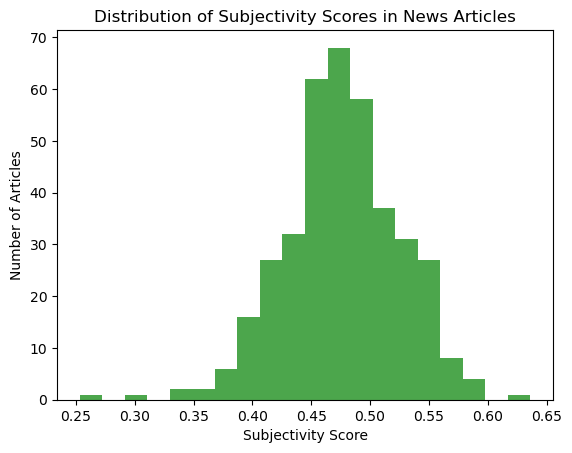

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of subjectivity scores
subjectivity_scores = [article["subjectivity_score"] for article in news_articles]

# Plotting the subjectivity score distribution
plt.hist(subjectivity_scores, bins=20, color='green', alpha=0.7)

# Adding labels and title
plt.xlabel('Subjectivity Score')
plt.ylabel('Number of Articles')
plt.title('Distribution of Subjectivity Scores in News Articles')

# Display the plot
plt.show()

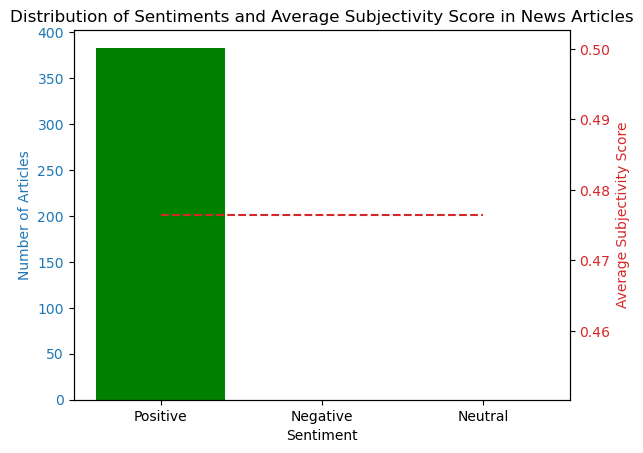

In [28]:
import matplotlib.pyplot as plt

# Assuming you have a list of sentiment labels and subjectivity scores
sentiments = [article["sentiment"] for article in news_articles]
subjectivity_scores = [article["subjectivity_score"] for article in news_articles]

# Count the occurrences of each sentiment
sentiment_counts = {
    "Positive": sentiments.count("Positive"),
    "Negative": sentiments.count("Negative"),
    "Neutral": sentiments.count("Neutral")
}

# Plotting the bar chart
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Number of Articles', color=color)
ax1.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'gray'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Subjectivity Score', color=color)
ax2.plot(sentiment_counts.keys(), [sum(subjectivity_scores) / len(subjectivity_scores)] * len(sentiment_counts), color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

# Adding labels and title
plt.title('Distribution of Sentiments and Average Subjectivity Score in News Articles')

# Display the plot
plt.show()


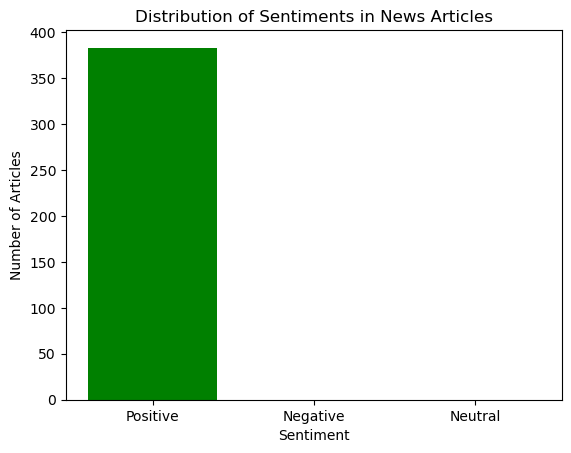

In [19]:
import matplotlib.pyplot as plt

# Assuming you have a list of sentiment labels
sentiments = [article["sentiment"] for article in news_articles]

# Count the occurrences of each sentiment
sentiment_counts = {
    "Positive": sentiments.count("Positive"),
    "Negative": sentiments.count("Negative"),
    "Neutral": sentiments.count("Neutral")
}

# Plotting the bar chart
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'gray'])

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.title('Distribution of Sentiments in News Articles')

# Display the plot
plt.show()


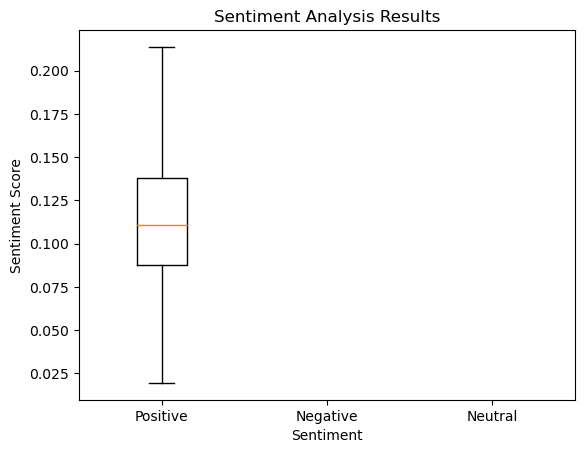

In [18]:
import matplotlib.pyplot as plt

# Assuming you have a list of sentiment scores
positive_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Positive"]
negative_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Negative"]
neutral_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Neutral"]

# Combine the scores into a list for boxplot
data = [positive_scores, negative_scores, neutral_scores]

# Plotting the boxplot
plt.boxplot(data, labels=["Positive", "Negative", "Neutral"], showfliers=False)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis Results')

# Display the plot
plt.show()

/Users/yimi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yimi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


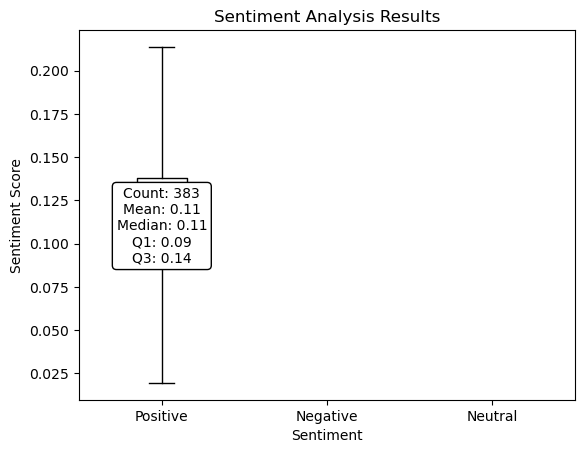

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of sentiment scores
positive_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Positive"]
negative_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Negative"]
neutral_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Neutral"]

# Combine the scores into a list for boxplot
data = [positive_scores, negative_scores, neutral_scores]

# Calculate additional statistics
statistics = {}
for sentiment, scores in zip(["Positive", "Negative", "Neutral"], data):
    stats = {
        "Count": len(scores),
        "Mean": np.mean(scores),
        "Median": np.median(scores),
    }
    # Add percentiles only if there are scores available
    if len(scores) > 0:
        stats["Q1"] = np.percentile(scores, 25)
        stats["Q3"] = np.percentile(scores, 75)
    statistics[sentiment] = stats

# Plotting the boxplot
boxplot = plt.boxplot(data, labels=["Positive", "Negative", "Neutral"], showfliers=False)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis Results')

# Annotating the boxplot with statistics
for i, label in enumerate(["Positive", "Negative", "Neutral"]):
    box = boxplot['boxes'][i]
    y = box.get_ydata()[0]
    stats = statistics[label]
    annotation = f"Count: {stats['Count']}\nMean: {stats['Mean']:.2f}\nMedian: {stats['Median']:.2f}"
    if "Q1" in stats and "Q3" in stats:
        annotation += f"\nQ1: {stats['Q1']:.2f}\nQ3: {stats['Q3']:.2f}"
    plt.text(i + 1, y, annotation, ha='center', va='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Display the plot
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


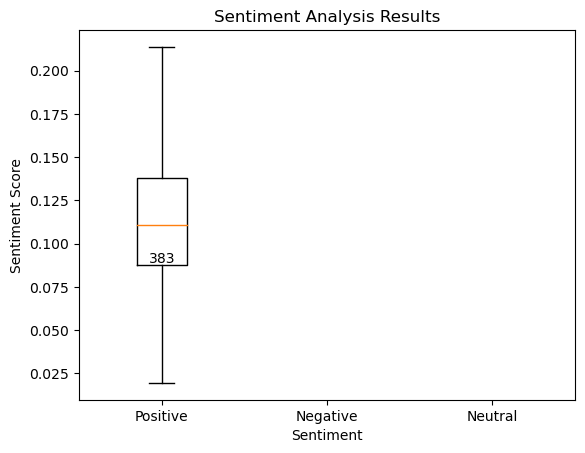

In [20]:
import matplotlib.pyplot as plt

# Assuming you have a list of sentiment scores
positive_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Positive"]
negative_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Negative"]
neutral_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Neutral"]

# Combine the scores into a list for boxplot
data = [positive_scores, negative_scores, neutral_scores]

# Plotting the boxplot
boxplot = plt.boxplot(data, labels=["Positive", "Negative", "Neutral"], showfliers=False)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis Results')

# Annotating the boxplot with counts
for i, box in enumerate(boxplot['boxes']):
    y = box.get_ydata()[0]
    count = len(data[i])
    plt.text(i + 1, y, f'{count}', ha='center', va='bottom')

# Display the plot
plt.show()

In [33]:

# Process each article title and perform sentiment analysis
for idx, article in enumerate(news_articles):
    title_text = article["title"]  # Assuming "title" is the correct field name
    
    # Create a TextBlob object for the title
    blob = TextBlob(title_text)
    
    # Perform sentiment analysis
    sentiment_score = blob.sentiment.polarity
    
    # Interpret the sentiment score
    if sentiment_score > 0:
        sentiment = "Positive"
    elif sentiment_score < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    
    # Add sentiment information to the article dictionary
    article["title_sentiment"] = sentiment
    article["title_sentiment_score"] = sentiment_score

    # print or store the sentiment information
    print(f"Article {idx + 1} Title Sentiment: {sentiment}")
    print(f"Article {idx + 1} Title Sentiment Score: {sentiment_score}")
    print("-" * 50)

Article 1 Title Sentiment: Neutral
Article 1 Title Sentiment Score: 0.0
--------------------------------------------------
Article 2 Title Sentiment: Neutral
Article 2 Title Sentiment Score: 0.0
--------------------------------------------------
Article 3 Title Sentiment: Neutral
Article 3 Title Sentiment Score: 0.0
--------------------------------------------------
Article 4 Title Sentiment: Neutral
Article 4 Title Sentiment Score: 0.0
--------------------------------------------------
Article 5 Title Sentiment: Neutral
Article 5 Title Sentiment Score: 0.0
--------------------------------------------------
Article 6 Title Sentiment: Negative
Article 6 Title Sentiment Score: -0.1
--------------------------------------------------
Article 7 Title Sentiment: Positive
Article 7 Title Sentiment Score: 0.2
--------------------------------------------------
Article 8 Title Sentiment: Neutral
Article 8 Title Sentiment Score: 0.0
--------------------------------------------------
Article 9 Tit

In [34]:
from textblob import TextBlob

# Process each article and perform sentiment analysis
for idx, article in enumerate(news_articles):
    article_text = article["title"]
    
    # Create a TextBlob object
    blob = TextBlob(article_text)
    
    # Perform sentiment analysis
    sentiment_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity
    
    # Interpret the sentiment score
    if sentiment_score > 0:
        sentiment = "Positive"
    elif sentiment_score < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    
    # Add sentiment information to the article dictionary
    article["sentiment"] = sentiment
    article["sentiment_score"] = sentiment_score
    article["subjectivity_score"] = subjectivity_score

    # print or store the sentiment information
    print(f"Article {idx + 1} Sentiment: {sentiment}")
    print(f"Article {idx + 1} Sentiment Score: {sentiment_score}")
    print(f"Article {idx + 1} Subjectivity Score: {subjectivity_score}")
    print("-" * 50)

Article 1 Sentiment: Neutral
Article 1 Sentiment Score: 0.0
Article 1 Subjectivity Score: 0.0
--------------------------------------------------
Article 2 Sentiment: Neutral
Article 2 Sentiment Score: 0.0
Article 2 Subjectivity Score: 0.0
--------------------------------------------------
Article 3 Sentiment: Neutral
Article 3 Sentiment Score: 0.0
Article 3 Subjectivity Score: 0.0
--------------------------------------------------
Article 4 Sentiment: Neutral
Article 4 Sentiment Score: 0.0
Article 4 Subjectivity Score: 0.0
--------------------------------------------------
Article 5 Sentiment: Neutral
Article 5 Sentiment Score: 0.0
Article 5 Subjectivity Score: 0.0
--------------------------------------------------
Article 6 Sentiment: Negative
Article 6 Sentiment Score: -0.1
Article 6 Subjectivity Score: 0.7
--------------------------------------------------
Article 7 Sentiment: Positive
Article 7 Sentiment Score: 0.2
Article 7 Subjectivity Score: 0.2
---------------------------------

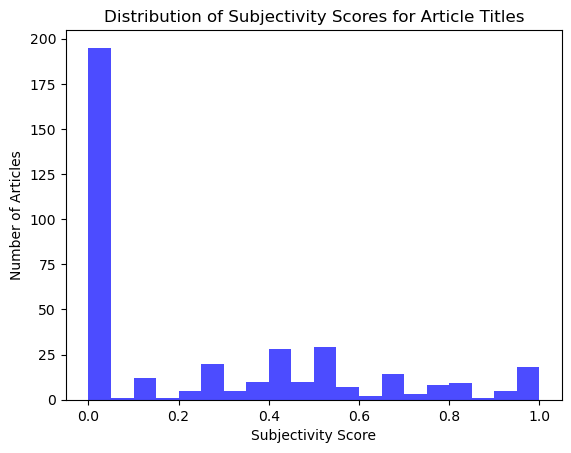

In [36]:
import matplotlib.pyplot as plt

# Assuming you have a list of subjectivity scores for titles
subjectivity_scores = [article["subjectivity_score"] for article in news_articles]

# Plotting the subjectivity score distribution using a histogram
plt.hist(subjectivity_scores, bins=20, color='blue', alpha=0.7)

# Adding labels and title
plt.xlabel('Subjectivity Score')
plt.ylabel('Number of Articles')
plt.title('Distribution of Subjectivity Scores for Article Titles')

# Display the plot
plt.show()

<AxesSubplot:>

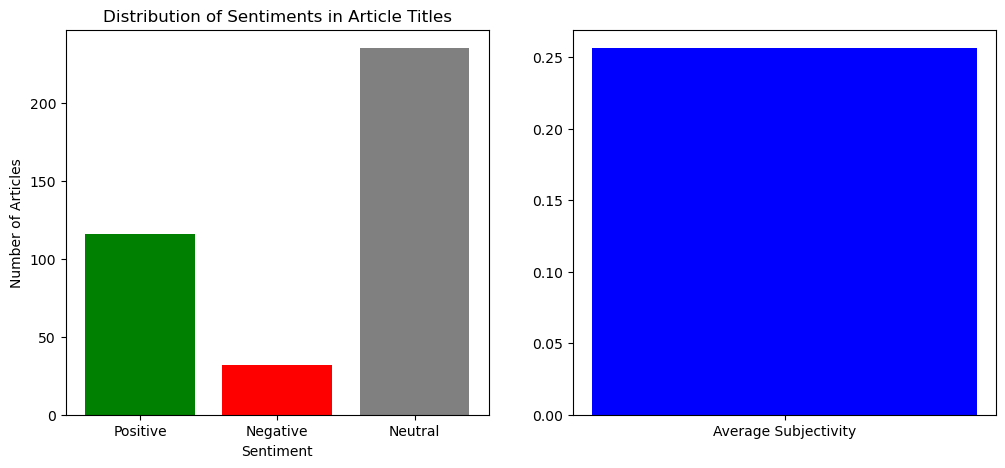

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of sentiment labels and subjectivity scores for titles
sentiments = [article["sentiment"] for article in news_articles]
subjectivity_scores = [article["subjectivity_score"] for article in news_articles]

# Count the occurrences of each sentiment
sentiment_counts = {
    "Positive": sentiments.count("Positive"),
    "Negative": sentiments.count("Negative"),
    "Neutral": sentiments.count("Neutral")
}

# Calculate the average subjectivity score
average_subjectivity = np.mean(subjectivity_scores)

# Plotting the bar chart for sentiment counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'gray'])
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Number of Articles')
ax1.set_title('Distribution of Sentiments in Article Titles')

# Plotting the average subjectivity score
ax2.bar(['Average Subjectivity'], [average_subjectivity], color='blue')
ax2

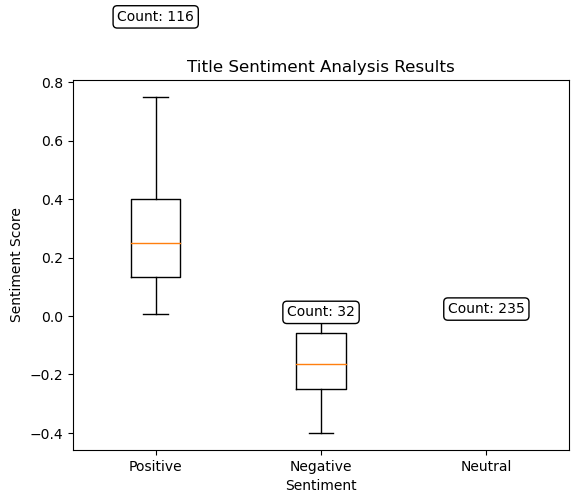

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of sentiment scores for title sentiment analysis
positive_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Positive"]
negative_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Negative"]
neutral_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Neutral"]

# Combine the scores into a list for boxplot
data = [positive_scores, negative_scores, neutral_scores]

# Calculate counts
counts = [len(positive_scores), len(negative_scores), len(neutral_scores)]

# Plotting the boxplot
boxplot = plt.boxplot(data, labels=["Positive", "Negative", "Neutral"], showfliers=False)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Title Sentiment Analysis Results')

# Annotating the boxplot with counts
for i, count in enumerate(counts):
    plt.text(i + 1, max(data[i]), f"Count: {count}", ha='center', va='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Display the plot
plt.show()


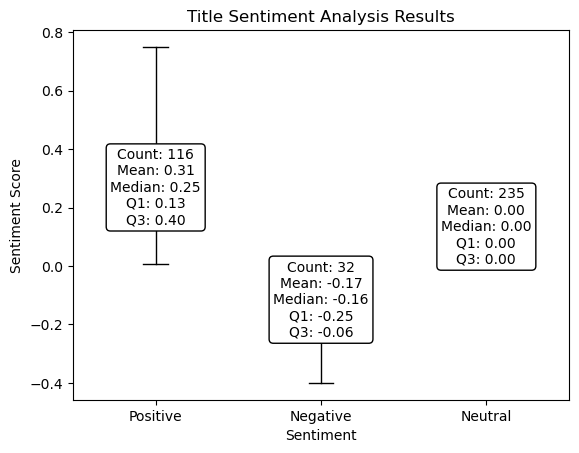

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of sentiment scores for title sentiment analysis
positive_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Positive"]
negative_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Negative"]
neutral_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Neutral"]

# Combine the scores into a list for boxplot
data = [positive_scores, negative_scores, neutral_scores]

# Calculate additional statistics
statistics = {}
for sentiment, scores in zip(["Positive", "Negative", "Neutral"], data):
    stats = {
        "Count": len(scores),
        "Mean": np.mean(scores),
        "Median": np.median(scores),
    }
    # Add percentiles only if there are scores available
    if len(scores) > 0:
        stats["Q1"] = np.percentile(scores, 25)
        stats["Q3"] = np.percentile(scores, 75)
    statistics[sentiment] = stats

# Plotting the boxplot
boxplot = plt.boxplot(data, labels=["Positive", "Negative", "Neutral"], showfliers=False)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Title Sentiment Analysis Results')

# Annotating the boxplot with statistics
for i, label in enumerate(["Positive", "Negative", "Neutral"]):
    box = boxplot['boxes'][i]
    y = box.get_ydata()[0]
    stats = statistics[label]
    annotation = f"Count: {stats['Count']}\nMean: {stats['Mean']:.2f}\nMedian: {stats['Median']:.2f}"
    if "Q1" in stats and "Q3" in stats:
        annotation += f"\nQ1: {stats['Q1']:.2f}\nQ3: {stats['Q3']:.2f}"
    plt.text(i + 1, y, annotation, ha='center', va='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Display the plot
plt.show()


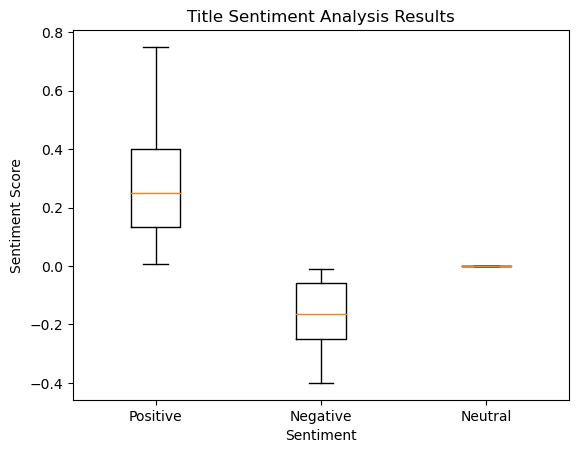

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of sentiment scores for title sentiment analysis
positive_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Positive"]
negative_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Negative"]
neutral_scores = [article["sentiment_score"] for article in news_articles if article["sentiment"] == "Neutral"]

# Combine the scores into a list for boxplot
data = [positive_scores, negative_scores, neutral_scores]

# Plotting the boxplot
boxplot = plt.boxplot(data, labels=["Positive", "Negative", "Neutral"], showfliers=False)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Title Sentiment Analysis Results')

# Display the plot
plt.show()

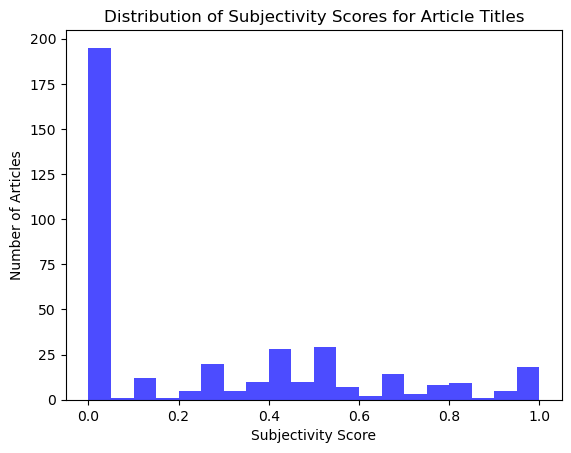

Number of articles with Low Subjectivity: 225
Number of articles with Moderate Subjectivity: 109
Number of articles with High Subjectivity: 49


In [43]:
import matplotlib.pyplot as plt

# A list of subjectivity scores for titles
subjectivity_scores = [article["subjectivity_score"] for article in news_articles]

# Define categories based on subjectivity score ranges
low_subjectivity = [score for score in subjectivity_scores if score < 0.3]
moderate_subjectivity = [score for score in subjectivity_scores if 0.3 <= score < 0.7]
high_subjectivity = [score for score in subjectivity_scores if score >= 0.7]

# Plotting the subjectivity score distribution using a histogram
plt.hist(subjectivity_scores, bins=20, color='blue', alpha=0.7)

# Adding labels and title
plt.xlabel('Subjectivity Score')
plt.ylabel('Number of Articles')
plt.title('Distribution of Subjectivity Scores for Article Titles')

# Display the plot
plt.show()

# Print numbers for each category
print(f"Number of articles with Low Subjectivity: {len(low_subjectivity)}")
print(f"Number of articles with Moderate Subjectivity: {len(moderate_subjectivity)}")
print(f"Number of articles with High Subjectivity: {len(high_subjectivity)}")
